# _Set Up: Trial 20_
### July 3, 2019

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# fastai libraries
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import EarlyStoppingCallback

In [3]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os
from pathlib import Path

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [4]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

# _Load in Data_

In [5]:
from test_folder import replicate

sample_df = replicate.load_data(path, 1, percent=0.05);

Added valid column
------------------------------
Extracted Patient ID from Path column and created new column named Patient_id
------------------------------
Concatenated train_df and valid_df, resulting shape = (223648, 21)
------------------------------
Created function named seed_data to set seed for sample data
------------------------------
Seeded data.
------------------------------
Created sample dataframe with input seed and 5.0% of original data
Resulting sample df has shape of (11810, 21)
------------------------------


In [6]:
sample_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,Patient_id
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003
44,CheXpert-v1.0-small/train/patient00015/study1/...,Female,76,Frontal,AP,NaN,NaN,NaN,1.0,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,False,patient00015
45,CheXpert-v1.0-small/train/patient00015/study2/...,Female,76,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,1.0,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,False,patient00015
93,CheXpert-v1.0-small/train/patient00028/study1/...,Male,70,Frontal,PA,NaN,0.0,NaN,-1.0,NaN,NaN,0.0,NaN,-1.0,0.0,0.0,NaN,NaN,NaN,False,patient00028
94,CheXpert-v1.0-small/train/patient00028/study2/...,Male,71,Frontal,AP,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN,False,patient00028


In [7]:
sample_df = replicate.dl_dataframe_setup(sample_df, 'Cardiomegaly');

Created data set with expressed competition pathology, replacing NaN's with 0 and resetting the index
------------------------------

Cardiomegaly
------------------------------
Shape of sample_df: (11810, 3)


In [8]:
sample_df.head()

,Path,valid,Cardiomegaly
0,CheXpert-v1.0-small/train/patient00003/study1/...,False,0.0
1,CheXpert-v1.0-small/train/patient00015/study1/...,False,0.0
2,CheXpert-v1.0-small/train/patient00015/study2/...,False,0.0
3,CheXpert-v1.0-small/train/patient00028/study1/...,False,0.0
4,CheXpert-v1.0-small/train/patient00028/study2/...,False,0.0


In [9]:
sample_df['Cardiomegaly'].value_counts()

 0.0    9987
 1.0    1378
-1.0     445
Name: Cardiomegaly, dtype: int64

In [10]:
sample_df = replicate.uzero(sample_df, 'Cardiomegaly');

Replaced -1 observations with 0.
------------------------------
Converted pathology column into integer type.
------------------------------


In [11]:
sample_df['Cardiomegaly'].value_counts()

0    10432
1     1378
Name: Cardiomegaly, dtype: int64

# _Set Up for Deep Learning_

In [12]:
src = replicate.get_src(sample_df, path, 'Cardiomegaly');

In [13]:
data = replicate.get_data(64, src)

using bs=16, have 7601MB of GPU RAM free.
------------------------------
Data ready.


In [14]:
data

ImageDataBunch;

Train: LabelList (11576 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

# _Set Up DL Model_

In [15]:
# create a pretrained densenet121 cnn_learner with error rate and AUROC as the metrics with a ps of 0.5 (i.e. 50% of randomly selected neurons will be ignored from the n-1 layer) and batch normalization
learn = cnn_learner(data=data, base_arch=models.densenet121, metrics=[error_rate, AUROC()], pretrained=True,
                     ps=0.5, bn_final=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E+01
Min loss divided by 10: 1.00E-01


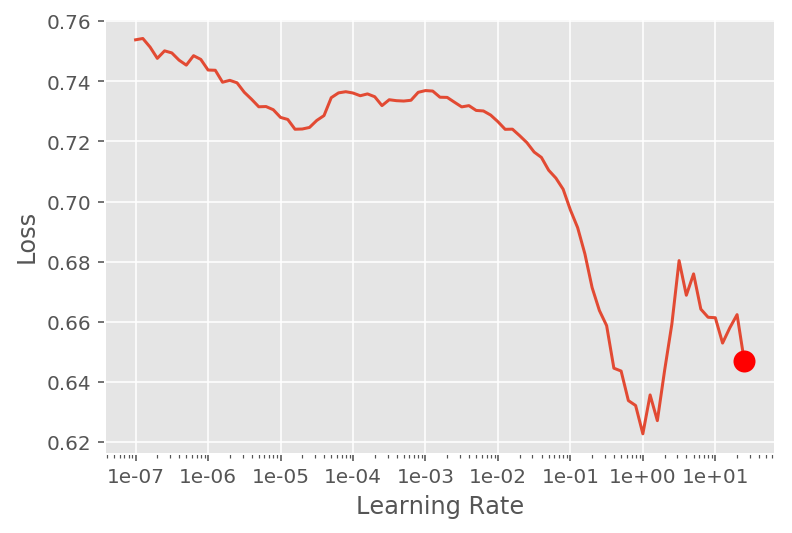

In [16]:
from test_folder import deeplearning

deeplearning.lr_finder_plot(learn)

In [50]:
lr = 3e-1
lr

0.3

In [18]:
# check the loss function
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

# _First Round of Training_

In [20]:
learn.fit_one_cycle(3, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.372760,16.661602,0.290598,0.450921,01:26
1,0.381753,0.895190,0.294872,0.506644,01:25
2,0.336013,0.692685,0.290598,0.737952,01:26


# _Update Data to Size = 128_

In [22]:
data128 = replicate.get_data(128, src)
data128

using bs=16, have 7026MB of GPU RAM free.
------------------------------
Data ready.


ImageDataBunch;

Train: LabelList (11576 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

In [23]:
# assign data128 to model
learn.data = data128

# _Second Round of Training_

In [24]:
learn.fit_one_cycle(3, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.354021,0.796103,0.290598,0.530386,01:29
1,0.382569,0.990026,0.294872,0.547661,01:30
2,0.321685,0.685045,0.290598,0.749646,01:30


In [25]:
learn.save('trial20-rd2')

# _Update Data to Size = 256_

In [26]:
data256 = replicate.get_data(256, src)
data256

using bs=16, have 7026MB of GPU RAM free.
------------------------------
Data ready.


ImageDataBunch;

Train: LabelList (11576 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

In [27]:
# assign data256 to model
learn.data = data256

# _Third Round of Training_

In [29]:
learn.load('trial20-rd2');

In [30]:
learn.fit_one_cycle(3, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.366570,12.688159,0.581197,0.663271,02:50
1,0.334548,0.862543,0.290598,0.664422,02:47
2,0.324983,0.685656,0.290598,0.694366,02:48


In [31]:
learn.save('trial20-rd3')

# _Update Data to Size = 320_
- Same size used by group at Stanford

In [32]:
data320 = replicate.get_data(320, src)
data320

using bs=16, have 6956MB of GPU RAM free.
------------------------------
Data ready.


ImageDataBunch;

Train: LabelList (11576 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

In [33]:
# assign data320 to model
learn.data = data320

# _Fourth Round of Training_

In [34]:
learn.load('trial20-rd3');

In [35]:
learn.fit_one_cycle(3, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.375018,6.885056,0.384615,0.447511,04:21
1,0.360626,727.374451,0.709402,0.500000,04:11
2,0.342317,0.721313,0.290598,0.744242,04:10


In [36]:
learn.save('trial20-rd4')

# _Fifth Round of Training_

In [51]:
learn.load('trial20-rd4');

In [52]:
# unfreeze all layers so we can refine the lower layers
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-06
Min loss divided by 10: 1.26E-08


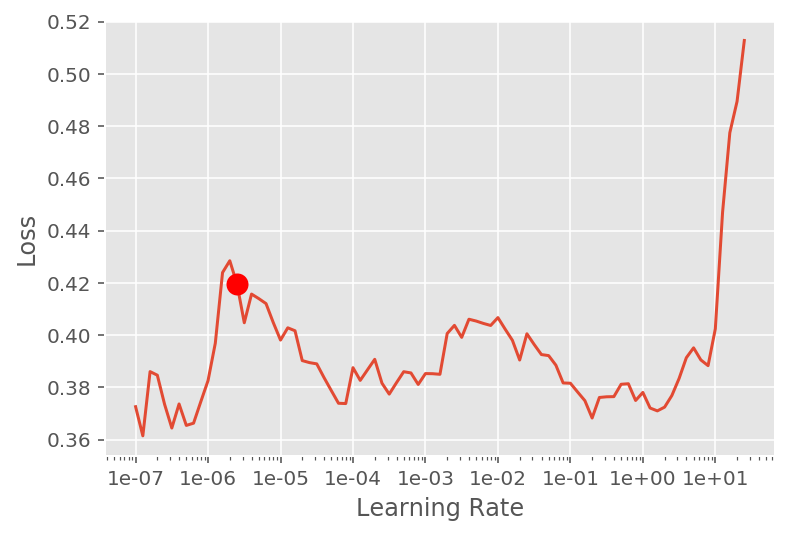

In [53]:
from test_folder import deeplearning

deeplearning.lr_finder_plot(learn)

In [54]:
# assign different learning rates to lower layers and higher layers
learn.fit_one_cycle(3, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.366397,0.687455,0.290598,0.615255,05:37
1,0.366642,0.772830,0.290598,0.518604,05:37
2,0.351327,0.691147,0.286325,0.715450,05:37


In [45]:
learn.save('trial20-rd5')

# _Sixth Round of Training_

In [46]:
learn.freeze()
learn.load('trial20-rd5');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.26E-08


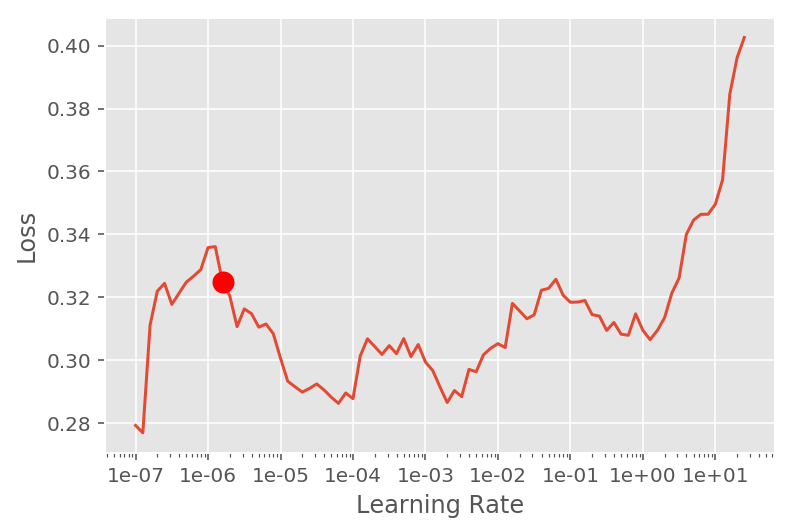

In [47]:
from test_folder import deeplearning

deeplearning.lr_finder_plot(learn)

In [48]:
lr = 1e-5
lr

1e-05

In [49]:
learn.fit_one_cycle(3, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.339947,0.679207,0.290598,0.688076,04:11
1,0.332815,0.691927,0.290598,0.678685,04:10
2,0.317080,0.912276,0.290598,0.679128,04:11
